In [2]:
import numpy as np
import copy
import matplotlib
import matplotlib.pyplot as plt
# from mpl_toolkits.mplot3d import Axes3D

In [3]:
import torch
import torch.nn as nn
import torch.nn.functional as F

from torchvision import datasets, transforms as T
from torch.utils import data

In [4]:
from tqdm import tqdm
import os, time, sys
import json

In [5]:
import dtnnlib as dtnn
# import resnet_cifar

In [6]:
mnist_transform = T.Compose([
    T.ToTensor(),
    T.Normalize(
        mean=0.5,
        std=0.5,
    ),
])

# train_dataset = datasets.FashionMNIST(root="../../../_Datasets/", train=True, download=True, transform=mnist_transform)
# test_dataset = datasets.FashionMNIST(root="../../../_Datasets/", train=False, download=True, transform=mnist_transform)
train_dataset = datasets.MNIST(root="../../../_Datasets/", train=True, download=True, transform=mnist_transform)
test_dataset = datasets.MNIST(root="../../../_Datasets/", train=False, download=True, transform=mnist_transform)

In [7]:
train_dataset.data.shape

torch.Size([60000, 28, 28])

In [8]:
batch_size = 50
train_loader = data.DataLoader(dataset=train_dataset, num_workers=4, batch_size=batch_size, shuffle=True)
test_loader = data.DataLoader(dataset=test_dataset, num_workers=4, batch_size=batch_size, shuffle=False)

In [9]:
device = torch.device("cpu")

In [10]:
for xx, yy in train_loader:
    print(xx.shape)
    xx, yy = xx.view(-1,28*28).to(device), yy.to(device)
    print(xx.shape, yy.shape)
    break

torch.Size([50, 1, 28, 28])
torch.Size([50, 784]) torch.Size([50])


## Train Test method

In [11]:
criterion = nn.CrossEntropyLoss()

In [12]:
## Following is copied from 
### https://github.com/kuangliu/pytorch-cifar/blob/master/main.py

# Training
def train(epoch, model, optimizer):
    model.train()
    train_loss = 0
    correct = 0
    total = 0
    for batch_idx, (inputs, targets) in enumerate(tqdm(train_loader)):
        inputs, targets = inputs.to(device).view(-1, 28*28), targets.to(device)
        
        ### Train with random image and "10" as class
#         inputs = torch.cat([inputs, torch.rand(batch_size//10, 28*28, dtype=inputs.dtype).to(device)*2-1], dim=0)
#         targets = torch.cat([targets, torch.ones(batch_size//10, dtype=targets.dtype).to(device)*10], dim=0)
        
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()

        train_loss += loss.item()
        _, predicted = outputs.max(1)
        total += targets.size(0)
        correct += predicted.eq(targets).sum().item()
    print(f"[Train] {epoch} Loss: {train_loss/(batch_idx+1):.3f} | Acc: {100.*correct/total:.3f} {correct}/{total}")
    return

In [13]:
best_acc = -1
def test(epoch, model, model_name, save=False):
    global best_acc
    model.eval()
    test_loss = 0
    correct = 0
    total = 0
    with torch.no_grad():
        for batch_idx, (inputs, targets) in enumerate(tqdm(test_loader)):
            inputs, targets = inputs.to(device).view(-1, 28*28), targets.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, targets)

            test_loss += loss.item()
            _, predicted = outputs.max(1)
            total += targets.size(0)
            correct += predicted.eq(targets).sum().item()
            
    print(f"[Test] {epoch} Loss: {test_loss/(batch_idx+1):.3f} | Acc: {100.*correct/total:.3f} {correct}/{total}")
    
    # Save checkpoint.
    acc = 100.*correct/total
    if acc > best_acc:
        print('Saving..')
        state = {
            'model': model.state_dict(),
            'acc': acc,
            'epoch': epoch,
        }
        if save:
            if not os.path.isdir('models'):
                os.mkdir('models')
            torch.save(state, f'./models/{model_name}.pth')
        best_acc = acc

## Models

In [184]:
class DistanceTransform_Epsilon(dtnn.DistanceTransformBase):
    
    def __init__(self, input_dim, num_centers, p=2, bias=False, epsilon=0.1):
        super().__init__(input_dim, num_centers, p=2)
        
        nc = num_centers
        if epsilon is not None:
            nc += 1
        self.scaler = nn.Parameter(torch.log(torch.ones(1, 1)*1))
#         self.scaler = nn.Parameter(torch.log(torch.ones(1, nc)*1))
        self.bias = nn.Parameter(torch.ones(1, nc)*0) if bias else None
        self.epsilon = epsilon
        
    def forward(self, x):
        dists = super().forward(x)
        
        if self.epsilon is not None:
            dists = torch.cat([dists, torch.ones(len(x), 1, dtype=x.dtype)*self.epsilon], dim=1)
        
        ### normalize similar to UMAP
#         dists = dists/torch.sqrt(dists.var(dim=1, keepdim=True)+1e-9)
        
    
        #### for norm
#         dists = torch.exp(-dists) ### solves degenerate cases of centers != maxima & also needed for norm
#         dists = -dists + dists.max(dim=1, keepdim=True)[0] ## replacement for e^{-d} -> making similarity (and also better)
        dists = dists/(torch.norm(dists, dim=1, keepdim=True)/(dists.shape[-1]**0.5)+1e-9)
        
        ## scale the dists
#         dists = torch.exp(-dists.abs()+self.scaler)
#         dists = 1-dists*torch.exp(self.scaler) ## use with simple or /std
        dists = dists*torch.exp(self.scaler) ## use with norm
    
        if self.bias is not None: dists = dists+self.bias
        return dists

In [185]:
class LocalMLP_epsilonsoftmax(nn.Module):
    
    def __init__(self, input_dim, hidden_dim, output_dim, epsilon=1.0):
        super().__init__()
        
        self.input_dim = input_dim
        self.hidden_dim = hidden_dim
        self.new_hidden_dim = 0
        self.output_dim = output_dim
        
        self.layer0 = DistanceTransform_Epsilon(self.input_dim, self.hidden_dim, bias=True, epsilon=epsilon)
        hdim = self.hidden_dim
        if epsilon is not None:
            hdim += 1
            
        self.scale_shift = dtnn.ScaleShift(hdim, scaler_init=3, shifter_init=0, scaler_const=True, shifter_const=True)
#         self.scale_shift = dtnn.ScaleShift(hdim, scaler_init=10, shifter_init=0, scaler_const=True, shifter_const=True)
        self.softmax = nn.Softmax(dim=-1)
#         self.softmax = F.gumbel_softmax

#         self.activ = dtnn.OneActiv(hdim, mode='exp_1.6', beta_init=np.log(2))
        self.activ = dtnn.OneActiv(hdim, mode='relu', beta_init=np.log(1.2))
#         self.activ = nn.ReLU()

        self.layer1 = nn.Linear(hdim, self.output_dim)
    
        self.temp_maximum = None
        
    def forward(self, x):
        xo = self.layer0(x)
        ## dropout here creates 0 actv (is relatively high), hence serves as noise --> does not work for high values
#         xo = F.dropout(xo, p=0.001, training=self.training)
        xo = self.scale_shift(xo)
        xo = self.softmax(xo)
        self.temp_maximum = xo.data
        
        ## drouout here is suitable for activation function (the probabilities do not add upto 1)
#         xo = F.dropout(xo, p=0.1, training=self.training)
        
        ### This feature is useful when the softmax has uniform and low probability
#         xo = xo/xo.max(dim=1, keepdim=True)[0].detach() ## produces poor decision boundary 
        
#         rejected = torch.count_nonzero(xo.argmax(dim=1) == self.hidden_dim) 
        xo = self.activ(xo)
        xo = self.layer1(xo)
        return xo

In [186]:
H = 100

model = LocalMLP_epsilonsoftmax(784, H, 11, epsilon=9.0) ## epsilon=9.0 used for std and no-std
# model = LocalMLP_epsilonsoftmax(784, H, 11, epsilon=20.0) ## epsilon=9.0 used for std and no-std
model_name = "epsilonSM_MLP_ep9_nostd" 

# model = LocalMLP_epsilonsoftmax(784, H, 11, epsilon=None)
# model_name = "epsilonSM_MLP_epNone"

model

LocalMLP_epsilonsoftmax(
  (layer0): DistanceTransform_Epsilon()
  (scale_shift): ScaleShift()
  (softmax): Softmax(dim=-1)
  (activ): OneActiv()
  (layer1): Linear(in_features=101, out_features=11, bias=True)
)

In [187]:
model(xx).shape

torch.Size([50, 11])

In [188]:
model.training

True

In [189]:
idx = torch.randperm(len(train_loader.dataset))[:H]
source, target = train_dataset.data[idx].reshape(-1, 784), train_dataset.targets[idx]
source.shape, target.shape

(torch.Size([100, 784]), torch.Size([100]))

In [190]:
# model.layer0.centers.data = source.type(torch.float32)/128-1 ## initialization

model.layer0.centers.data = source.type(torch.float32)/128-1 #\
#                 + torch.rand_like(model.layer0.centers.data)-0.5 ## initialization

# model.layer0.centers.data /= torch.max(model.layer0.centers.data) ## initialization

In [191]:
targets = torch.zeros(len(target), 11)
for i, t in enumerate(target):
    targets[i, t] = 1.
    targets[i,-1] = 0.05

if model.layer0.epsilon is not None:
    e = torch.zeros(1, 11)
    e[0,-1] = 1.
    targets = torch.cat([targets, e], dim=0)

targets.shape
# targets[-1]

torch.Size([101, 11])

In [192]:
model.layer1.weight.data = targets.t()#.to(device) ## initialization

In [193]:
def forward_intermediate(self, x):
    xo = self.layer0(x)
    xo = self.scale_shift(xo)
    xo = self.softmax(xo).data
    print(xo.shape)
    print(xo.mean(dim=0), "\n ", xo.std(dim=0))
    print(xo.min(dim=0)[0], "\n ", xo.max(dim=0)[0])

forward_intermediate(model, xx)

torch.Size([50, 101])
tensor([0.0111, 0.0113, 0.0118, 0.0102, 0.0070, 0.0083, 0.0108, 0.0118, 0.0091,
        0.0096, 0.0088, 0.0148, 0.0120, 0.0107, 0.0085, 0.0115, 0.0131, 0.0105,
        0.0053, 0.0065, 0.0099, 0.0122, 0.0073, 0.0084, 0.0129, 0.0070, 0.0116,
        0.0069, 0.0113, 0.0090, 0.0113, 0.0120, 0.0094, 0.0094, 0.0080, 0.0112,
        0.0102, 0.0085, 0.0095, 0.0104, 0.0087, 0.0092, 0.0095, 0.0061, 0.0098,
        0.0072, 0.0113, 0.0084, 0.0111, 0.0120, 0.0059, 0.0112, 0.0129, 0.0071,
        0.0058, 0.0095, 0.0066, 0.0111, 0.0105, 0.0135, 0.0119, 0.0066, 0.0059,
        0.0103, 0.0122, 0.0100, 0.0116, 0.0093, 0.0059, 0.0087, 0.0059, 0.0069,
        0.0097, 0.0073, 0.0074, 0.0127, 0.0086, 0.0051, 0.0082, 0.0076, 0.0076,
        0.0075, 0.0095, 0.0135, 0.0116, 0.0108, 0.0107, 0.0072, 0.0082, 0.0102,
        0.0086, 0.0125, 0.0096, 0.0081, 0.0124, 0.0094, 0.0078, 0.0107, 0.0089,
        0.0103, 0.0465]) 
  tensor([0.0042, 0.0031, 0.0073, 0.0045, 0.0041, 0.0024, 0.0027, 0.0026

In [194]:
test(-1, model, model_name="", save=False)

100%|██████████████████████████████████████████████████| 200/200 [00:01<00:00, 153.59it/s]

[Test] -1 Loss: 2.395 | Acc: 11.350 1135/10000


## Model Training

In [195]:
learning_rate = 0.01
"""
Use Small LR for centers and larger for rest (center deviated too much)
"""

EPOCHS = 15

In [196]:
### https://stackoverflow.com/questions/51801648/how-to-apply-layer-wise-learning-rate-in-pytorch
p1, p2 = [], []
for p in model.named_parameters():
    if p[0] == "layer0.centers":
        p1.append(p[1])
    else:
        p2.append(p[1])

params = [
    {"params": p1, "lr": learning_rate*3e-2}, ## default - to change little from data point
#     {"params": p1},
    {"params": p2},
]

In [197]:
# optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

optimizer = torch.optim.Adam(params, lr=learning_rate)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=EPOCHS)

best_acc = -1
for epoch in range(EPOCHS):
    train(epoch, model, optimizer)
    test(epoch, model, model_name, save=False)
    scheduler.step()

100%|████████████████████████████████████████████████| 1200/1200 [00:10<00:00, 119.17it/s]


[Train] 0 Loss: 2.314 | Acc: 10.913 6548/60000


100%|██████████████████████████████████████████████████| 200/200 [00:01<00:00, 145.40it/s]


[Test] 0 Loss: 2.304 | Acc: 11.350 1135/10000
Saving..


  4%|█▉                                                 | 47/1200 [00:00<00:13, 84.82it/s]


KeyboardInterrupt: 

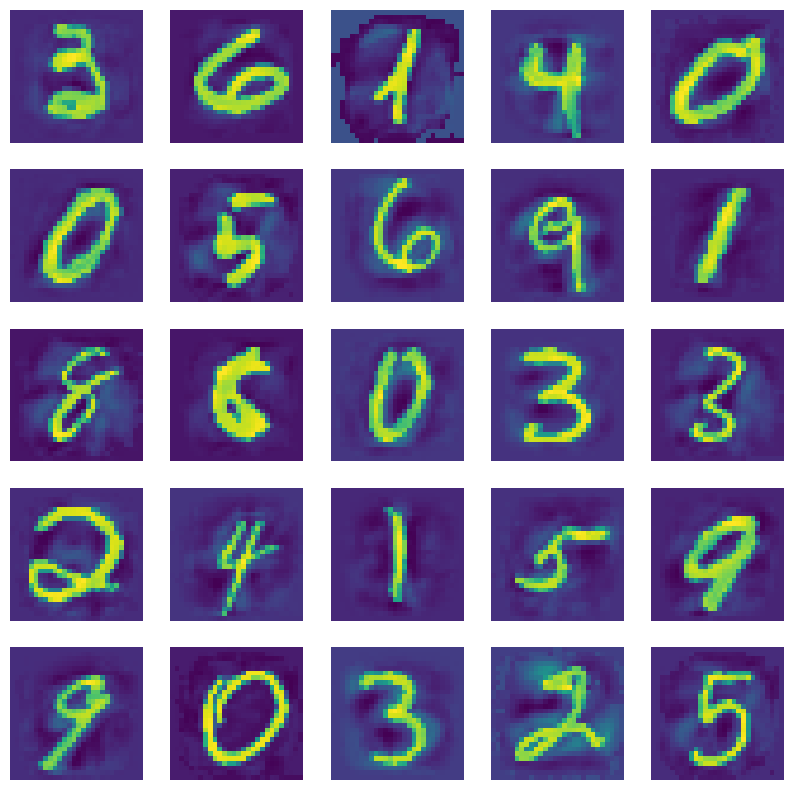

In [109]:
_, axs = plt.subplots(5, 5, figsize=(10, 10))
axs = axs.flatten()

c = model.layer0.centers.data.cpu().numpy().reshape(-1, 28,28)
imgs = c[:len(axs)]

for img, ax in zip(imgs, axs):
    ax.imshow(img)
    ax.set_axis_off()

plt.show()

#### Test for random image sample

In [110]:
with torch.no_grad():
    inputs = torch.rand(10, 28*28).to(device)*2-1
    xo = model.layer0(inputs)
    xo = model.scale_shift(xo)
    xo = model.softmax(xo).data

In [111]:
# xo.argmax(dim=1)
xo.max(dim=1)

torch.return_types.max(
values=tensor([0.9998, 0.9999, 0.9999, 0.9999, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        0.9998]),
indices=tensor([100, 100, 100, 100, 100, 100, 100, 100, 100, 100]))

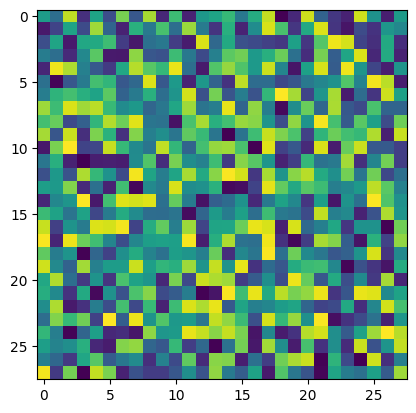

In [112]:
j=0
plt.imshow(inputs[j].reshape(28,28))

In [113]:
i = -1
nearest = torch.argsort(xo[j], descending=True)
nearest

tensor([100,  98,  15,  23,  35,  82,  90,  49,   0,  93,  64,  51,   4,  41,
         78,  58,  19,  88,  59,   1,  61,  25,   5,  12,  45,   7,  72,  80,
         75,  97,  22,  87,  28,  27,  30,  33,  11,   3,  92,  67,  21,  85,
         68,  66,  13,  71,  34,  46,   8,  37,  62,  99,  18,  20,  94,  42,
         40,  52,  26,  73,  83,  84,  91,  56,  16,  96,  48,   9,  39,  74,
         50,  57,  76,  17,  38,   6,  89,  54,  69,  77,  14,  79,  24,  53,
         81,  44,  55,  86,  29,  10,  95,  60,  65,  36,  63,  32,  43,   2,
         70,  47,  31])

In [114]:
xo.shape

torch.Size([10, 101])

In [115]:
i+=1
print("prob:", xo[0][nearest[i]])
try:
    plt.imshow(model.layer0.centers.data[nearest[i]].reshape(28,28))
except:
    pass

prob: tensor(0.9998)


In [116]:
with torch.no_grad():
    xo_ = model.activ(xo)
    xo_ = model.layer1(xo_).data

In [117]:
xo_.argmax(dim=1)

tensor([4, 4, 4, 4, 4, 4, 4, 4, 4, 4])

In [118]:
#  model.layer1.weight[1], model.layer1.weight[10]

In [119]:
## scaling of softmax activation
torch.exp(model.activ.beta)

tensor([[0.9961, 1.0022, 1.3025, 0.9947, 0.9957, 0.9960, 1.0336, 0.9992, 0.9937,
         1.0081, 1.0460, 0.9828, 0.9948, 1.0018, 1.0440, 0.9947, 1.0023, 1.0336,
         0.9992, 0.9826, 0.9853, 1.0571, 0.9948, 0.9982, 1.0246, 1.0025, 1.0608,
         0.9934, 0.9991, 1.1514, 0.9984, 1.0105, 1.0384, 0.9932, 0.9943, 0.9987,
         1.0132, 0.9993, 1.0464, 1.0040, 1.0026, 0.9895, 0.9889, 1.0321, 1.0306,
         1.0070, 1.0014, 1.0084, 0.9992, 0.9966, 0.9903, 1.0024, 1.0004, 1.0476,
         1.0957, 1.0414, 0.9881, 1.1632, 0.9858, 1.0183, 1.0327, 0.9985, 1.0079,
         1.0633, 1.0011, 0.9829, 0.9965, 0.9956, 0.9972, 1.0174, 1.0538, 1.0007,
         1.0039, 0.9931, 1.0058, 0.9904, 1.2736, 1.0094, 1.0013, 1.0939, 0.9962,
         1.1535, 0.9986, 0.9981, 1.0090, 1.0081, 1.0144, 1.0069, 1.0062, 1.0514,
         0.9967, 1.0026, 0.9984, 1.0047, 1.1378, 1.0728, 0.9933, 0.9864, 0.9980,
         0.9895, 1.0025]], grad_fn=<ExpBackward>)

In [120]:
imgs.min(), imgs.max()

(-1.5683028, 1.4303712)

In [121]:
model.layer1.weight.data[:,5]

tensor([ 5.4754, -4.6243, -1.1677, -5.1153, -3.3043, -4.5984,  0.1756, -3.9587,
        -1.3592, -4.3568, -3.8641])

## Adverserial Test

In [122]:
import foolbox as fb
import foolbox.attacks as fa

In [137]:
# fmodel = fb.PyTorchModel(model.eval(), bounds=(-1, 1), device=device)
fmodel = fb.PyTorchModel(model.eval(), bounds=(-10, 10), device=device)


# attack = fa.LinfPGD()
# attack = fa.L2AdamPGD()
attack = fa.FGSM()
# epsilons = [0.0, 0.001, 0.01, 0.03, 0.1, 0.3, 0.5, 1.0]

In [138]:
count = 0
failed = 0
rejected = 0
x_rejected = 0
for i, (xx, yy) in enumerate(tqdm(test_loader)):
    xx = xx.reshape(-1, 28*28)
    
    yout = model(xx)
    reject_out = yout.argmax(dim=1) == 10
    reject_hid = model.temp_maximum.max(dim=1)[1] == model.hidden_dim
    reject = torch.bitwise_or(reject_out, reject_hid)
    x_rejected += int(reject.type(torch.float32).sum())
    
    _, advs, success = attack(fmodel, xx, yy, epsilons=0.5)   
    yout = model(advs)
    reject_out = yout.argmax(dim=1) == 10
    reject_hid = model.temp_maximum.max(dim=1)[1] == model.hidden_dim
    reject = torch.bitwise_or(reject_out, reject_hid)
#     reject = reject_out
    rejected += int(reject.type(torch.float32).sum())
    
    fail = torch.bitwise_and(success, ~reject).type(torch.float32).sum()
#     fail = success.type(torch.float32).sum()
    failed += int(fail)    
    count += len(xx)

#     break

100%|███████████████████████████████████████████████████| 200/200 [00:02<00:00, 95.88it/s]


In [139]:
# success

In [140]:
count, failed, rejected, x_rejected

(10000, 3646, 5680, 449)

In [141]:
(failed+x_rejected)/count

0.4095

In [1119]:
# model.temp_maximum.max(dim=1)[1]

In [1120]:
# yout.argmax(dim=1)

In [136]:
model.layer0.epsilon = 15.
# model.layer0.epsilon = -1.5

In [1122]:
"""
- not using \std on dists causes the centers to move very little from initialization (even with large lr)... 
        and have better adverserial rejection
- norm does not seem to work like std (poor optimization)
- not clipping adverserial examples [0-1] causes less attack success.. (maximum of +-1.5 with FSGM)
"""
print()

In [1123]:
advs

tensor([[-0.5000, -1.5000, -1.5000,  ..., -0.5000, -1.5000, -0.5000],
        [-0.5000, -0.5000, -0.5000,  ..., -1.5000, -0.5000, -1.5000],
        [-0.5000, -1.5000, -1.5000,  ..., -1.5000, -0.5000, -1.5000],
        ...,
        [-1.0104, -0.9939, -1.0037,  ..., -0.9833, -1.0090, -0.9833],
        [-0.5000, -0.5000, -1.5000,  ..., -0.5000, -1.5000, -1.5000],
        [-0.5000, -1.5000, -0.5000,  ..., -0.5000, -0.5000, -0.5000]])

In [1124]:
advs.max()

tensor(1.5000)